**Load Results Files**

In [2]:
import nibabel as nib

PROJECT_ROOT = "C:/Users/hapla/Documents/GitHub/albert-plante_project"
SUBJECT = "0204"

RESULTSDIR = f"{PROJECT_ROOT}/results/results_{SUBJECT}"
TEMPLATE_DIR = f"{PROJECT_ROOT}/data/derivatives/templates"

mp2rage_path = f"{RESULTSDIR}/mp2rage_mni.nii.gz"
t1_map_path = f"{RESULTSDIR}/t1_map_mni.nii.gz"
fa_path = f"{RESULTSDIR}/fa_map_mni.nii.gz"
dwi_path = f"{RESULTSDIR}/dwi_mni.nii.gz"
seg_mp2rage_path = f"{RESULTSDIR}/seg_mp2rage_mni.nii.gz"
seg_dwi_path = f"{RESULTSDIR}/seg_dwi_mni.nii.gz"
seg_atlas_path = f"{TEMPLATE_DIR}/Optic_Nerve_Label_MNI.nii.gz"


mp2rage = nib.load(mp2rage_path).get_fdata()
t1_map= nib.load(t1_map_path).get_fdata()
fa_map = nib.load(fa_path).get_fdata()
dwi = nib.load(dwi_path).get_fdata()
seg_mp2rage = nib.load(seg_mp2rage_path).get_fdata()
seg_dwi  = nib.load(seg_dwi_path).get_fdata()
seg_atlas = nib.load(seg_atlas_path).get_fdata()

C:\Users\hapla\AppData\Local\Temp\ipykernel_30084\1709447970.py:49: RuntimeWarning: invalid value encountered in sqrt
  g_ratio_vals = [np.sqrt(1 - (mvf / fvf)) for mvf, fvf in zip(mvf_vals, fvf_vals)]


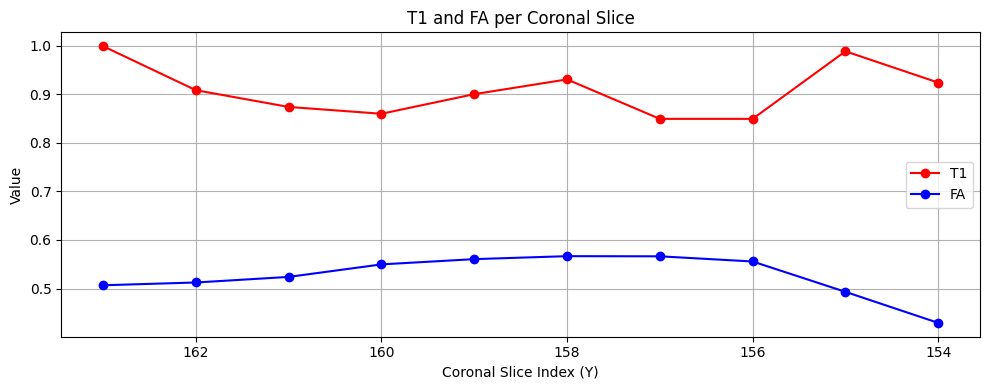

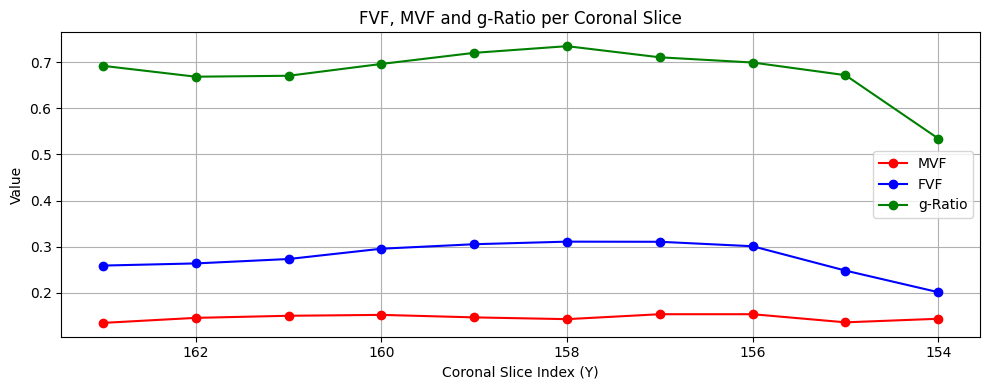

In [3]:
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Create mask of overlap ===
mask_overlap = (seg_mp2rage > 0) & (seg_dwi > 0)

# === Mask the T1 and FA maps ===
masked_t1_map = np.zeros_like(t1_map)
masked_fa_map = np.zeros_like(fa_map)
masked_t1_map[mask_overlap] = t1_map[mask_overlap]
masked_fa_map[mask_overlap] = fa_map[mask_overlap]

# === Compute T1 values and FA values by coronal slice ===
mean_t1_by_slice = {}
mean_fa_by_slice = {}

for y in range(masked_t1_map.shape[1]):
    slice_t1 = masked_t1_map[:, y, :]
    vals_t1 = slice_t1[slice_t1 > 0]

    slice_fa = masked_fa_map[:, y, :]
    vals_fa = slice_fa[slice_fa > 0]

    if vals_t1.size > 0:
        mean_t1_by_slice[y] = np.mean(vals_t1)

    if vals_fa.size > 0:
        mean_fa_by_slice[y] = np.mean(vals_fa) / 1000  # normalize if needed

slice_ids = []
mean_vals_t1 = []
mean_vals_fa = []

for y in sorted(mean_t1_by_slice.keys()):
    if y in mean_fa_by_slice:
        slice_ids.append(y)
        mean_vals_t1.append(mean_t1_by_slice[y])
        mean_vals_fa.append(mean_fa_by_slice[y]) 

mtvf_vals = []
for t1 in mean_vals_t1:
    mtvf = 1 - 1 / ((0.42202 / t1) + 0.94766) if t1 > 0 else 0
    mtvf_vals.append(mtvf)

mvf_vals = [mtvf * 0.5 for mtvf in mtvf_vals]
fvf_vals = [0.883*fa**2-0.082*fa+0.074 for fa in mean_vals_fa]
g_ratio_vals = [np.sqrt(1 - (mvf / fvf)) for mvf, fvf in zip(mvf_vals, fvf_vals)]

plt.figure(figsize=(10, 4))
plt.plot(slice_ids[5:15], mean_vals_t1[5:15], label='T1', marker='o', color='red')
plt.plot(slice_ids[5:15], mean_vals_fa[5:15], label='FA', marker='o', color='blue')
plt.xlabel("Coronal Slice Index (Y)")
plt.ylabel("Value")
plt.title("T1 and FA per Coronal Slice")
plt.grid(True)
plt.legend()
plt.gca().invert_xaxis()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(slice_ids[5:15], mvf_vals[5:15], label='MVF', marker='o', color='red')
plt.plot(slice_ids[5:15], fvf_vals[5:15], label='FVF', marker='o', color='blue')
plt.plot(slice_ids[5:15], g_ratio_vals[5:15], label='g-Ratio', marker='o', color='green')
plt.xlabel("Coronal Slice Index (Y)")
plt.ylabel("Value")
plt.title("FVF, MVF and g-Ratio per Coronal Slice")
plt.grid(True)
plt.legend()
plt.gca().invert_xaxis()
plt.tight_layout()
plt.show()